<a href="https://colab.research.google.com/github/ndhend/winc_academy_assingments/blob/master/Shark_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dropped all the columns I will not need and kept only those I will use

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

url = 'https://raw.githubusercontent.com/ndhend/csv_data_winc/main/attacks.csv'
df = pd.read_csv(url)
# display(shark_attacks.head())
df.columns

# Only selecting the columns I will most probably use
df1 = df.loc[:,['Type','Activity','Age', 'Injury', 'Fatal (Y/N)', 'Species ']]
# shark_attacks
df2 = df1.dropna()
df3 = df2.rename(columns={'Fatal (Y/N)': 'Fatal(Y/N)', 'Species ': 'Species'})
df3 = df3.reset_index(drop=True)
# display(df3.columns)


# Looking for non-default missing data
def print_separator(sep, num, msg):
  print("\n")
  print(sep * num)
  print(f"{msg}")
  print(sep * num)


def look_at_unique_values(column):
  unique_values_cutoff = 500
  unique_values = column.unique()
  num_unique_values = len(unique_values)
  if num_unique_values == len(column):
    print(f"Each value in the column is unique (total: {num_unique_values})")
  elif num_unique_values < unique_values_cutoff:
    print(f"Less than {unique_values_cutoff} unique values:")
    # We may get an error when sorting
    try:
      sorted = np.sort(unique_values)
      print("Values are sorted")
      display(list(sorted))
    except:
      print("Could not sort values")
      display(list(unique_values))
  else:
    print(f"More than {unique_values_cutoff} unique values (total: {num_unique_values})")


def look_at_edges(df, column_name):
  # inner function
  def show_head_and_tail(values):
      num_items_to_slice = 10
      display(list(values)[:num_items_to_slice])
      display(list(values)[-num_items_to_slice:])

  column = df[column_name]
  unique_values = column.unique()
  try:
      sorted = np.sort(unique_values)
      print("Unique values sorted, head and tail:")
      show_head_and_tail(sorted)
  except TypeError as error:
      print(f"Could not sort values: {error}")
      print("..so let's try filtering NULL values and then sorting")
      non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
      sorted = np.sort(non_null_uniques)
      show_head_and_tail(sorted)

def cast_to_type(column, maybe_type):
  try:
    column.astype(maybe_type)
    print(f"Casting to {maybe_type} was successful")
  except ValueError as error:
    print(f"Could not cast to {maybe_type}: {error}")

def find_non_default_missing_values(df, column_name, maybe_type):
  long_separator_amount = 80
  short_separator_amount = 40

  print_separator("*", long_separator_amount, f"Finding non default missing values for column \"{column_name}\"")

  print(f"Column \"{column_name}\" has datatype: {df.dtypes[column_name]}")

  column = df[column_name]


  # A
  print_separator("-", short_separator_amount, "A: Looking at unique values")
  look_at_unique_values(column)

  # B
  print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
  look_at_edges(df, column_name)

  # C
  print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
  cast_to_type(column, maybe_type)


  # D
  print_separator("-", short_separator_amount, "D: Looking at frequency")
  display(column.value_counts(dropna=False))

  print("\n")

def replace_value(df, column_name, missing_old, missing_new):
#   # ⚠️ Mutates df
  df[column_name] = df[column_name].replace({missing_old: missing_new})

# ✅ Type
replace_value(df3, 'Type', 'Invalid', None)
# find_non_default_missing_values(df3, 'Type',"string")


# ✅ Activity
replace_value(df3, 'Activity', '   ', None)
# find_non_default_missing_values(df3, 'Activity','string')

# ✅ Age / Average_Age
replace_value(df3, 'Age', ' ', np.nan)
replace_value(df3, 'Age', '"young"', np.nan)
replace_value(df3, 'Age', 'MAKE LINE GREEN', np.nan)
replace_value(df3, 'Age', 'Teen',np.nan)
replace_value(df3, 'Age', '� ',np.nan)
replace_value(df3, 'Age', 'adult', np.nan)
replace_value(df3, 'Age', 'teen', np.nan)
replace_value(df3, 'Age', '18 months', '1.5')
replace_value(df3, 'Age', '9 months', '0.75')

# find_non_default_missing_values(df3, 'Age','float64')

def average_age(age_str):
    if pd.notna(age_str) and 'or' in age_str:
        numbers = re.findall(r'\d+', age_str)
        if numbers:
            avg_age = sum(map(int, numbers)) / len(numbers)
            return (avg_age)
    return None

# Identify rows where the 'Age' column contains 'or'
rows_with_or = df3['Age'].str.contains('or', na=False)
# display(rows_with_or)

# # Create a new DataFrame with the updated rows
updated_rows = df3[rows_with_or].copy()
# display(updated_rows)
updated_rows['Age'] = df3[rows_with_or]['Age'].apply(average_age)
# display(updated_rows['Age'])
# # Append the updated rows to the original DataFrame
df3 = pd.concat([df3, updated_rows], ignore_index=True)
# display(df3)

def split_ages(age_str):
    age_str = str(age_str)
    if 'Both' not in age_str:
        return re.findall(r'(\d+\.\d+|\d+)', age_str)  # Use a modified pattern to capture floating-point numbers
    elif 'Both' in age_str:
        # Extract the number after 'Both' and create two rows with that number
        number = re.findall(r'\d+', age_str)
        if number:
            return number * 2
    return [age_str]

# Apply the function to the 'Age' column and create two new columns
df3['Adjusted_Age'] = df3['Age'].apply(split_ages)

# Use explode to duplicate rows when 'Numbers' contains lists
df3 = df3.explode('Adjusted_Age', ignore_index=True)

# display(df3)

# find_non_default_missing_values(df3, 'Adjusted_Age','float64')


# ✅ Injury couldn't find missing data
# replace_value(df3, 'q2-lon', 0, np.nan)
# find_non_default_missing_values(df3, 'Injury', 'string')

# ✅ Fatal Y/N
df3['Fatal(Y/N)'] = df3['Fatal(Y/N)'].replace({' N': 'N'})
df3['Fatal(Y/N)'] = df3['Fatal(Y/N)'].replace({'2017': None, 'M': None})
# find_non_default_missing_values(df3,'Fatal(Y/N)','string')

# ✅ Species
replace_value(df3, 'Species', ' ', None)
replace_value(df3, 'Species', '� ', None)
replace_value(df3, 'Species', '�small brown shark�', 'small brown shark')
# find_non_default_missing_values(df3, 'Species', 'string')

df3 = df3.dropna()

# What are the most dangerous types of sharks to humans?
# Species, Fatal Y

fatal_sharks = df3[df3['Fatal(Y/N)'] == 'Y']

# Display the resulting DataFrame
# display(fatal_sharks)

shark_counts = fatal_sharks['Species'].value_counts()
# display(shark_counts)

# Are children more likely to be attacked by sharks?
# Age under a certain number vs Age above a certain age.




,Type,Activity,Age,Injury,Fatal(Y/N),Species,Adjusted_Age
0,Boating,Paddling,57,"No injury to occupant, outrigger canoe and pad...",N,White shark,57
1,Unprovoked,Swimming,18,FATAL,Y,Tiger shark,18
2,Unprovoked,Fishing,52,Minor injury to foot. PROVOKED INCIDENT,N,"Lemon shark, 3'",52
3,Unprovoked,Walking,15,Lower left leg bitten,N,"Bull shark, 6'",15
4,Provoked,Feeding sharks,32,Minor bite to hand by captive shark. PROVOKED ...,N,Grey reef shark,32
...,...,...,...,...,...,...,...
1962,Unprovoked,Surfing,33.0,Heel / foot bitten,N,"1.5 m [5'] ""whaler shark""",33.0
1963,Unprovoked,Swimming,15.5,"FATAL, left thigh bitten",Y,"Blue shark, 3 m [10']",15.5
1964,Unprovoked,Bending over,7.5,FATAL,Y,"Tiger shark, 3.7 m to 4.3 m [12' to 14']",7.5
1965,Unprovoked,"Swimming, naked",9.5,"Arm severed, but survived. Note: Some weeks la...",N,Bull shark,9.5


What are the most dangerous sharks?
White shark                                       40
Tiger shark                                       17
Bull shark                                        12

According to the graph 40 attacks of the White Shark were fatal, 17 of the Tiger Shark and 12 of the Bull shark. Therefore these three sharks are the most dangerous types to human of which the White Shark is the most dangerous.



19      83
18      77
15      73
16      73
20      72

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

url = 'https://raw.githubusercontent.com/ndhend/csv_data_winc/main/attacks.csv'
df = pd.read_csv(url)
# display(shark_attacks.head())
df.columns

# Only selecting the columns I will most probably use
df1 = df.loc[:,['Type','Activity','Age', 'Injury', 'Fatal (Y/N)', 'Species ']]
# shark_attacks
df2 = df1.dropna()
df3 = df2.rename(columns={'Fatal (Y/N)': 'Fatal(Y/N)', 'Species ': 'Species'})
df3 = df3.reset_index(drop=True)
# display(df3.columns)


# Looking for non-default missing data
def print_separator(sep, num, msg):
  print("\n")
  print(sep * num)
  print(f"{msg}")
  print(sep * num)


def look_at_unique_values(column):
  unique_values_cutoff = 500
  unique_values = column.unique()
  num_unique_values = len(unique_values)
  if num_unique_values == len(column):
    print(f"Each value in the column is unique (total: {num_unique_values})")
  elif num_unique_values < unique_values_cutoff:
    print(f"Less than {unique_values_cutoff} unique values:")
    # We may get an error when sorting
    try:
      sorted = np.sort(unique_values)
      print("Values are sorted")
      display(list(sorted))
    except:
      print("Could not sort values")
      display(list(unique_values))
  else:
    print(f"More than {unique_values_cutoff} unique values (total: {num_unique_values})")


def look_at_edges(df, column_name):
  # inner function
  def show_head_and_tail(values):
      num_items_to_slice = 10
      display(list(values)[:num_items_to_slice])
      display(list(values)[-num_items_to_slice:])

  column = df[column_name]
  unique_values = column.unique()
  try:
      sorted = np.sort(unique_values)
      print("Unique values sorted, head and tail:")
      show_head_and_tail(sorted)
  except TypeError as error:
      print(f"Could not sort values: {error}")
      print("..so let's try filtering NULL values and then sorting")
      non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
      sorted = np.sort(non_null_uniques)
      show_head_and_tail(sorted)

def cast_to_type(column, maybe_type):
  try:
    column.astype(maybe_type)
    print(f"Casting to {maybe_type} was successful")
  except ValueError as error:
    print(f"Could not cast to {maybe_type}: {error}")

def find_non_default_missing_values(df, column_name, maybe_type):
  long_separator_amount = 80
  short_separator_amount = 40

  print_separator("*", long_separator_amount, f"Finding non default missing values for column \"{column_name}\"")

  print(f"Column \"{column_name}\" has datatype: {df.dtypes[column_name]}")

  column = df[column_name]


  # A
  print_separator("-", short_separator_amount, "A: Looking at unique values")
  look_at_unique_values(column)

  # B
  print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
  look_at_edges(df, column_name)

  # C
  print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
  cast_to_type(column, maybe_type)


  # D
  print_separator("-", short_separator_amount, "D: Looking at frequency")
  display(column.value_counts(dropna=False))

  print("\n")

def replace_value(df, column_name, missing_old, missing_new):
#   # ⚠️ Mutates df
  df[column_name] = df[column_name].replace({missing_old: missing_new})

# ✅ Type
replace_value(df3, 'Type', 'Invalid', None)
# find_non_default_missing_values(df3, 'Type',"string")


# ✅ Activity
replace_value(df3, 'Activity', '   ', None)
# find_non_default_missing_values(df3, 'Activity','string')

# ✅ Age / Average_Age
replace_value(df3, 'Age', ' ', np.nan)
replace_value(df3, 'Age', '"young"', np.nan)
replace_value(df3, 'Age', 'MAKE LINE GREEN', np.nan)
replace_value(df3, 'Age', 'Teen',np.nan)
replace_value(df3, 'Age', '� ',np.nan)
replace_value(df3, 'Age', 'adult', np.nan)
replace_value(df3, 'Age', 'teen', np.nan)
replace_value(df3, 'Age', '18 months', '1.5')
replace_value(df3, 'Age', '9 months', '0.75')

# find_non_default_missing_values(df3, 'Age','float64')

def average_age(age_str):
    if pd.notna(age_str) and 'or' in age_str:
        numbers = re.findall(r'\d+', age_str)
        if numbers:
            avg_age = sum(map(int, numbers)) / len(numbers)
            return (avg_age)
    return None

# Identify rows where the 'Age' column contains 'or'
rows_with_or = df3['Age'].str.contains('or', na=False)
# display(rows_with_or)

# # Create a new DataFrame with the updated rows
updated_rows = df3[rows_with_or].copy()
# display(updated_rows)
updated_rows['Age'] = df3[rows_with_or]['Age'].apply(average_age)
# display(updated_rows['Age'])
# # Append the updated rows to the original DataFrame
df3 = pd.concat([df3, updated_rows], ignore_index=True)
# display(df3)

# Apply the function to the 'Age' column and create two new columns
df3['Adjusted_Age'] = df3['Age'].apply(split_ages)

# Use explode to duplicate rows when 'Numbers' contains lists
df3 = df3.explode('Adjusted_Age', ignore_index=True)

# display(df3)


import pandas as pd
import re

def split_ages(age_str):
    age_str = str(age_str)
    if 'Both' not in age_str:
        # Check if the string contains 's' at the end (e.g., '40s')
        if age_str[-1] == 's':
            age_str = age_str.rstrip('s')  # Remove 's' from the end of the string
            try:
                return int(age_str)  # Convert the remaining string to an integer
            except ValueError:
                return None  # If the string cannot be converted to an integer, return None
        else:
            # Use a modified pattern to capture floating-point numbers
            numbers = re.findall(r'(\d+\.\d+)', age_str)
            if not numbers:  # If no floating-point numbers are found, try to find integer numbers
                numbers = re.findall(r'(\d+)', age_str)
            if numbers:  # Return the first number found (could be an integer or floating-point number)
                return float(numbers[0])
    elif 'Both' in age_str:
        # Extract the number after 'Both'
        number = re.findall(r'\d+', age_str)
        if number:
            return float(number[0])
    return None

# Assuming df3 is your DataFrame with the 'Age' column
# Let's say your DataFrame looks like this:
# df3 = pd.DataFrame({'Name': ['John', 'Alice', 'Bob'],
#                     'Age': ['25', '30s', 'Both 40']})

# Apply the split_ages function to the 'Age' column and store the results in 'Adjusted_Age'
df3['Adjusted_Age'] = df3['Age'].apply(split_ages)

# Drop rows where 'Adjusted_Age' is None (i.e., rows with invalid format or 'Both' cases without a number)
df3 = df3.dropna(subset=['Adjusted_Age'])



# Display the DataFrame with both floating-point numbers and '40s' treated as integers in the 'Age' column
# print(df3)


# # Apply the function to the 'Age' column and create two new columns
# df3['Adjusted_Age'] = df3['Age'].apply(split_ages)

# # Use explode to duplicate rows when 'Numbers' contains lists
# df3 = df3.explode('Adjusted_Age', ignore_index=True)

# display(df3)

# find_non_default_missing_values(df3, 'Adjusted_Age','float64')


# ✅ Injury couldn't find missing data
# replace_value(df3, 'q2-lon', 0, np.nan)
# find_non_default_missing_values(df3, 'Injury', 'string')

# ✅ Fatal Y/N
df3['Fatal(Y/N)'] = df3['Fatal(Y/N)'].replace({' N': 'N'})
df3['Fatal(Y/N)'] = df3['Fatal(Y/N)'].replace({'2017': None, 'M': None})
# find_non_default_missing_values(df3,'Fatal(Y/N)','string')

# ✅ Species
replace_value(df3, 'Species', ' ', None)
replace_value(df3, 'Species', '� ', None)
replace_value(df3, 'Species', '�small brown shark�', 'small brown shark')
# find_non_default_missing_values(df3, 'Species', 'string')

df3 = df3.dropna()

# What are the most dangerous types of sharks to humans?
# Species, Fatal Y

fatal_sharks = df3[df3['Fatal(Y/N)'] == 'Y']

# Display the resulting DataFrame
# display(fatal_sharks)

shark_counts = fatal_sharks['Species'].value_counts()
# display(shark_counts)

# Are children more likely to be attacked by sharks?
# Age under a certain number vs Age above a certain age.

# Convert the 'Age' column to float64 type
df3['Adjusted_Age'] = df3['Adjusted_Age'].astype('float64')
# display(df3)
children = df3.loc[df3.Adjusted_Age < 18]
adults = df3.loc[df3.Adjusted_Age >= 18]

children_counts = children['Adjusted_Age'].value_counts()
# display(children_counts)
# For children_counts
total_children_counts = children_counts.iloc[:10]

adults_counts = adults['Adjusted_Age'].value_counts()
# For adults_counts
total_adults_counts = adults_counts.iloc[:10]
# display(total_adults_counts)

# Create a DataFrame to hold both series
# df3_counts = pd.DataFrame({'Adults': total_adults_counts, 'Children': total_children_counts})

# # Plot the vertical bar chart
# df3_counts.plot(kind='bar', color=['blue', 'orange'], edgecolor='black', grid=True)

# # Set labels and title
# plt.xlabel('Age Group')
# plt.ylabel('Count')
# plt.title('Total Counts by Age Group for Adults and Children')

# # Show the plot
# plt.show()










<ipython-input-3-29a4177c91ca>:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Adjusted_Age'] = df3['Adjusted_Age'].astype('float64')


According to the vertical barchart children are NOT more likely to be attacked by sharks as the lines in the adults part are higher than in the children parts. According to the graph would between the age of 15 and 21 humans are more likely to be attacked by sharks.

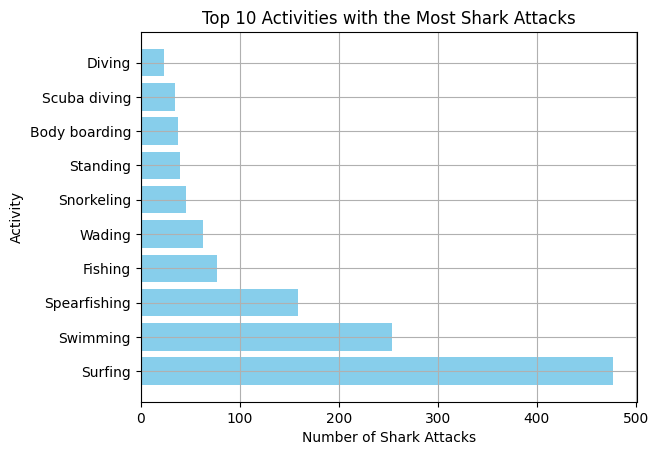

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

url = 'https://raw.githubusercontent.com/ndhend/csv_data_winc/main/attacks.csv'
df = pd.read_csv(url)
# display(shark_attacks.head())
df.columns

# Only selecting the columns I will most probably use
df1 = df.loc[:,['Type','Activity','Age', 'Injury', 'Fatal (Y/N)', 'Species ']]
# shark_attacks
df2 = df1.dropna()
df3 = df2.rename(columns={'Fatal (Y/N)': 'Fatal(Y/N)', 'Species ': 'Species'})
df3 = df3.reset_index(drop=True)
# display(df3.columns)


# Looking for non-default missing data
def print_separator(sep, num, msg):
  print("\n")
  print(sep * num)
  print(f"{msg}")
  print(sep * num)


def look_at_unique_values(column):
  unique_values_cutoff = 500
  unique_values = column.unique()
  num_unique_values = len(unique_values)
  if num_unique_values == len(column):
    print(f"Each value in the column is unique (total: {num_unique_values})")
  elif num_unique_values < unique_values_cutoff:
    print(f"Less than {unique_values_cutoff} unique values:")
    # We may get an error when sorting
    try:
      sorted = np.sort(unique_values)
      print("Values are sorted")
      display(list(sorted))
    except:
      print("Could not sort values")
      display(list(unique_values))
  else:
    print(f"More than {unique_values_cutoff} unique values (total: {num_unique_values})")


def look_at_edges(df, column_name):
  # inner function
  def show_head_and_tail(values):
      num_items_to_slice = 10
      display(list(values)[:num_items_to_slice])
      display(list(values)[-num_items_to_slice:])

  column = df[column_name]
  unique_values = column.unique()
  try:
      sorted = np.sort(unique_values)
      print("Unique values sorted, head and tail:")
      show_head_and_tail(sorted)
  except TypeError as error:
      print(f"Could not sort values: {error}")
      print("..so let's try filtering NULL values and then sorting")
      non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
      sorted = np.sort(non_null_uniques)
      show_head_and_tail(sorted)

def cast_to_type(column, maybe_type):
  try:
    column.astype(maybe_type)
    print(f"Casting to {maybe_type} was successful")
  except ValueError as error:
    print(f"Could not cast to {maybe_type}: {error}")

def find_non_default_missing_values(df, column_name, maybe_type):
  long_separator_amount = 80
  short_separator_amount = 40

  print_separator("*", long_separator_amount, f"Finding non default missing values for column \"{column_name}\"")

  print(f"Column \"{column_name}\" has datatype: {df.dtypes[column_name]}")

  column = df[column_name]


  # A
  print_separator("-", short_separator_amount, "A: Looking at unique values")
  look_at_unique_values(column)

  # B
  print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
  look_at_edges(df, column_name)

  # C
  print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
  cast_to_type(column, maybe_type)


  # D
  print_separator("-", short_separator_amount, "D: Looking at frequency")
  display(column.value_counts(dropna=False))

  print("\n")

def replace_value(df, column_name, missing_old, missing_new):
#   # ⚠️ Mutates df
  df[column_name] = df[column_name].replace({missing_old: missing_new})

# ✅ Type
replace_value(df3, 'Type', 'Invalid', None)
# find_non_default_missing_values(df3, 'Type',"string")


# ✅ Activity
replace_value(df3, 'Activity', '   ', None)
# find_non_default_missing_values(df3, 'Activity','string')

# ✅ Age / Average_Age
replace_value(df3, 'Age', ' ', np.nan)
replace_value(df3, 'Age', '"young"', np.nan)
replace_value(df3, 'Age', 'MAKE LINE GREEN', np.nan)
replace_value(df3, 'Age', 'Teen',np.nan)
replace_value(df3, 'Age', '� ',np.nan)
replace_value(df3, 'Age', 'adult', np.nan)
replace_value(df3, 'Age', 'teen', np.nan)
replace_value(df3, 'Age', '18 months', '1.5')
replace_value(df3, 'Age', '9 months', '0.75')

# find_non_default_missing_values(df3, 'Age','float64')

def average_age(age_str):
    if pd.notna(age_str) and 'or' in age_str:
        numbers = re.findall(r'\d+', age_str)
        if numbers:
            avg_age = sum(map(int, numbers)) / len(numbers)
            return (avg_age)
    return None

# Identify rows where the 'Age' column contains 'or'
rows_with_or = df3['Age'].str.contains('or', na=False)
# display(rows_with_or)

# # Create a new DataFrame with the updated rows
updated_rows = df3[rows_with_or].copy()
# display(updated_rows)
updated_rows['Age'] = df3[rows_with_or]['Age'].apply(average_age)
# display(updated_rows['Age'])
# # Append the updated rows to the original DataFrame
df3 = pd.concat([df3, updated_rows], ignore_index=True)
# display(df3)

import pandas as pd
import re

def split_ages(age_str):
    age_str = str(age_str)
    if 'Both' not in age_str:
        # Check if the string contains 's' at the end (e.g., '40s')
        if age_str[-1] == 's':
            age_str = age_str.rstrip('s')  # Remove 's' from the end of the string
            try:
                return int(age_str)  # Convert the remaining string to an integer
            except ValueError:
                return None  # If the string cannot be converted to an integer, return None
        else:
            # Use a modified pattern to capture floating-point numbers
            numbers = re.findall(r'(\d+\.\d+)', age_str)
            if not numbers:  # If no floating-point numbers are found, try to find integer numbers
                numbers = re.findall(r'(\d+)', age_str)
            if numbers:  # Return the first number found (could be an integer or floating-point number)
                return float(numbers[0])
    elif 'Both' in age_str:
        # Extract the number after 'Both'
        number = re.findall(r'\d+', age_str)
        if number:
            return float(number[0])
    return None

# Assuming df3 is your DataFrame with the 'Age' column
# Let's say your DataFrame looks like this:
# df3 = pd.DataFrame({'Name': ['John', 'Alice', 'Bob'],
#                     'Age': ['25', '30s', 'Both 40']})

# Apply the split_ages function to the 'Age' column and store the results in 'Adjusted_Age'
df3['Adjusted_Age'] = df3['Age'].apply(split_ages)

# Drop rows where 'Adjusted_Age' is None (i.e., rows with invalid format or 'Both' cases without a number)
df3 = df3.dropna(subset=['Adjusted_Age'])



# Display the DataFrame with both floating-point numbers and '40s' treated as integers in the 'Age' column
# print(df3)


# # Apply the function to the 'Age' column and create two new columns
# df3['Adjusted_Age'] = df3['Age'].apply(split_ages)

# # Use explode to duplicate rows when 'Numbers' contains lists
# df3 = df3.explode('Adjusted_Age', ignore_index=True)

# display(df3)

# find_non_default_missing_values(df3, 'Adjusted_Age','float64')


# ✅ Injury couldn't find missing data
# replace_value(df3, 'q2-lon', 0, np.nan)
# find_non_default_missing_values(df3, 'Injury', 'string')

# ✅ Fatal Y/N
df3['Fatal(Y/N)'] = df3['Fatal(Y/N)'].replace({' N': 'N'})
df3['Fatal(Y/N)'] = df3['Fatal(Y/N)'].replace({'2017': None, 'M': None})
# find_non_default_missing_values(df3,'Fatal(Y/N)','string')

# ✅ Species
replace_value(df3, 'Species', ' ', None)
replace_value(df3, 'Species', '� ', None)
replace_value(df3, 'Species', '�small brown shark�', 'small brown shark')
# find_non_default_missing_values(df3, 'Species', 'string')

df3 = df3.dropna()
# display(df3)

# Are shark attacks where sharks were provoked more or less dangerous?
# Type = Provoked vs Fatal
Provoked = df3[df3['Type'] == 'Provoked']
# display (Provoked)
Provoked_fatal = Provoked[Provoked['Fatal(Y/N)'] == 'Y']
# display (Provoked_fatal)
provoked_fatal_counts = Provoked_fatal['Fatal(Y/N)'].value_counts()
# display(provoked_fatal_counts) # Output: 4

Unprovoked = df3[df3['Type'] == 'Unprovoked']
# display(Unprovoked)
Unprovoked_fatal = Unprovoked[Unprovoked['Fatal(Y/N)'] == 'Y']
# display (Provoked_fatal)
unprovoked_fatal_counts = Unprovoked_fatal['Fatal(Y/N)'].value_counts()

# display(unprovoked_fatal_counts) # Output: 286

# Are certain activities more likely to result in a shark attack?
# Activities-> As the df only consists of shark attacks
# display(df3)
activity_counts = df3['Activity'].value_counts()
total_activity_counts = activity_counts.iloc[:10]
# display(total_activity_counts)


# Group the DataFrame by 'Activity' and calculate the number of shark attacks for each activity
activity_counts = df3['Activity'].value_counts()

# Sort the activities based on the number of shark attacks in descending order
sorted_activities = activity_counts.sort_values(ascending=False)

# Select the top 10 activities with the highest number of shark attacks
total_activity_counts = sorted_activities.iloc[:10]

# Plot the horizontal bar chart
plt.barh(total_activity_counts.index, total_activity_counts.values, color='skyblue')

# Set labels and title
plt.xlabel('Number of Shark Attacks')
plt.ylabel('Activity')
plt.title('Top 10 Activities with the Most Shark Attacks')

# Enable grid lines
plt.grid(True)
# Show the plot
plt.show()



Output:
Y    4
Name: Fatal(Y/N), dtype: int64
Y    286
Name: Fatal(Y/N), dtype: int64

Strangely enough, shark attacks where sharks are NOT provoked are way more dangerous than  shark attacks were the sharks were provoked. Maybe because when sharks are provoked, people are already aware of the danger and/or the presence of a shark.

Surfing is clearly more likely to result in a shark attack than the other activities.